# Supermarket Example

__author__ = "Rahul Kakodkar"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.0.7"
__maintainer__ = "Rahul Kakodkar"
__email__ = "cacodcar@tamu.edu"
__status__ = "Complete"


A chunk of the following code was submitted as part of the course requirement for ICPE 604 Energy Systems Engineering I offered as a part of the Master in Energy program at Texas A&M University by a team comprising of Cheonseong Lee, Ricardo Aragon, Andrew Houston, Kevin Klingaman, Riham Saoui

## Problem Statement

Given is a supermarket comprising of on-site energy conversion blocks and energy demands. The expected operating horizon of the supermarket is 20 years. The energy demands are listed in Table 1.

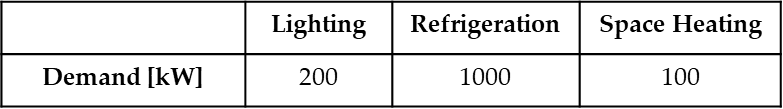

Primary energy resources include natural gas and biomass. Prices of the primary energy resources and grid electricity as well as their associated CO2 production is given in Table 2 – it should be noted that 1 [GJ] is approximately equal to 277.78 [KWh].


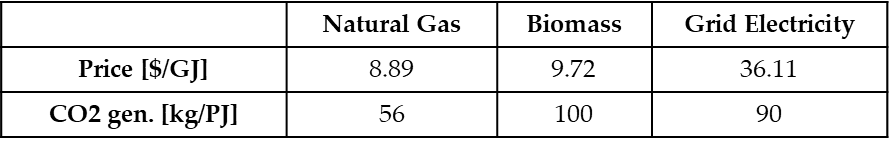

The on-site energy generation section involves two electricity generation technologies, one heat generation technology, and one co-production technology. The electrical efficiency (ηE), heating efficiency (ηH), minimum capacity if constructed (LB), maximum capacity if constructed (UB), capital cost (CAPEX), and operational cost (OPEX) are give in Table 3. Table 3: Technical and economic parameters of on-site energy generation technologies


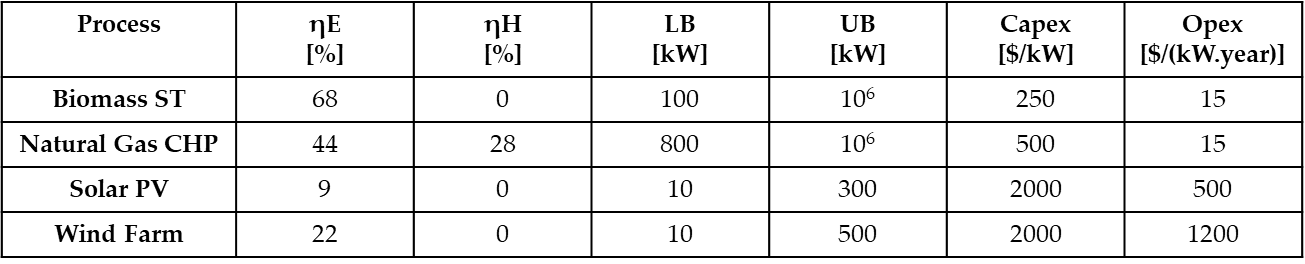

Two electricity driven energy conversion technologies and one heat driven energy conversion technologies is given in order to meet the demands of lighting, refrigeration, and space heating. The efficiency (or coefficient of performance, COP), types of energy input, types of utility output, capital cost and operational cost of these technologies are summarized in Table 4.

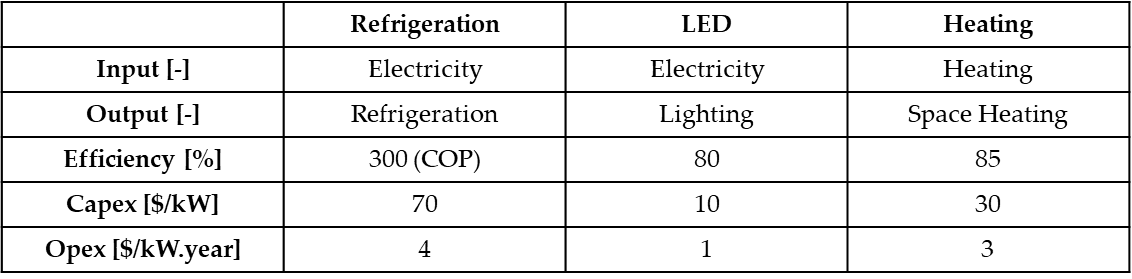

Determine system configurations for optimal cost, energy efficiency, and emission

In [5]:
import sys
sys.path.append('../../../src')

## Import modules

In [6]:
import pandas
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource
from energiapy.components.process import Process
from energiapy.components.location import Location
from energiapy.components.scenario import Scenario
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve

## Parameters

In [ ]:
resource_demand_dict = {'Lighting': 200,
               'Refrigeration': 1000,
               'Space Heating': 100}

resource_dict = {'Price': {'Natural Gas': 8.89, 'Biomass': 9.72, 'Grid Electricity': 36.11},
                       'CO2 Generation': {'Natural Gas': 56, 'Biomass': 100, 'Grid Electricity': 90}}

generation_process_dict = {'Biomass ST': {'nE': 68, 'nH': 0, 'LB': 100, 'UB': 10**6, 'Capex': 250, 'Opex': 15},
                           'Natural Gas CHP': {'nE': 44, 'nH': 28, 'LB': 800, 'UB': 10**6, 'Capex': 500, 'Opex': 15},
                           'Solar PV': {'nE': 9, 'nH': 0, 'LB': 10, 'UB': 300, 'Capex': 2000, 'Opex': 500},
                           'Wind Farm': {'nE': 22, 'nH': 0, 'LB': 10, 'UB': 500, 'Capex': 2000, 'Opex': 1200}}

consumption_process_dict = {'Refrigeration': {'Efficiency': 300, 'Capex': 80, 'Opex': 85},
                            'LED': {'Efficiency': 70, 'Capex': 10, 'Opex': 30},
                            'Heating': {'Efficiency': 4, 'Capex': 1, 'Opex': 3}}

## Temporal Scale

We will conside a single temporal scale representing the 20 year horizon

In [7]:
scales=TemporalScale(discretization_list=[1]) 

## Resources

Resources can be declared along with thier attributes such as maximum allowed consumption, dischargeablity, base price, etc.

In [8]:
BigM = 10**5

In [9]:
Biomass= Resource(name='Biomass', price= resource_dict['Price']['Biomass'], cons_max= BigM, basis='GJ', label='Biomass') #table 2

GridPower = Resource(name='GridPower', cons_max = BigM, price= resource_dict['Price']['Grid Electricity'], basis='GJ', label='Grid Electricity')

NG = Resource(name='NG', price= resource_dict['Price']['Natural Gas'], cons_max= BigM, basis='GJ', label='Natural gas')
Power=Resource(name='Power', basis='kW',label='Electrical Power')
Heat=Resource(name='Heat', basis='kW',label='Heat Power')

CO2_Vent = Resource(name='CO2_Vent', sell=True, basis='tons', label='Carbon dioxide')

Solar = Resource(name = 'Solar', cons_max= BigM, basis ='GJ', label ='Solar energy') 
Wind = Resource(name = 'Wind', cons_max= BigM, basis ='GJ', label ='Wind energy')

Lighting = Resource(name='Lighting', demand=True, basis='kW',label='Lighting')
Refrigeration = Resource(name='Refrigeration', demand=True, basis='kW',label='Refrigeration') 
Heating = Resource(name='Heating', demand=True, basis='kW',label='Heating')


## Processes

Processes convert one resource to another with a particular conversion efficiency while incurring a cost for setup (capital expenditure) and operation (operational expenditure)

In [12]:
ST= Process(name='BM_ST', conversion={Biomass: -1, Power: 277.78*generation_process_dict['Biomass ST']['nE']/100, CO2_Vent:resource_dict['CO2 Generation']['Biomass']}, 
            capex=generation_process_dict['Biomass ST']['Capex'], vopex=generation_process_dict['Biomass ST']['Opex'],prod_min=generation_process_dict['Biomass ST']['LB']
            , prod_max=generation_process_dict['Biomass ST']['UB'], label='Biomass ST', basis='PJ') #table 3 



CHP= Process(name='NG_CHP', conversion={NG: -1, Power: 277.78*generation_process_dict['Natural Gas CHP']['nE']/100, CO2_Vent: resource_dict['CO2 Generation']['Natural Gas'],
                                        Heat: 277.78*generation_process_dict['Natural Gas CHP']['nH']/100}, capex=generation_process_dict['Natural Gas CHP']['Capex'], 
             vopex=generation_process_dict['Natural Gas CHP']['Opex'], prod_max=generation_process_dict['Natural Gas CHP']['UB']
             , prod_min=generation_process_dict['Natural Gas CHP']['LB'], label='Natural Gas CHP', basis='PJ')


PV= Process(name='PV', conversion={Solar: -1, Power: 277.78*generation_process_dict['Solar PV']['nE']/100}, capex=generation_process_dict['Solar PV']['Capex'], 
            vopex=generation_process_dict['Solar PV']['Opex'], prod_max=generation_process_dict['Solar PV']['UB'], prod_min=generation_process_dict['Solar PV']['LB'], 
            label='Solar PV',  basis='kW')


WF= Process(name='WF',conversion={Wind: -1, Power: 277.78*generation_process_dict['Wind Farm']['nE']/100}, capex=generation_process_dict['Wind Farm']['Capex'], 
            vopex=generation_process_dict['Wind Farm']['Opex'], prod_max=generation_process_dict['Wind Farm']['UB'], prod_min=generation_process_dict['Wind Farm']['LB'], 
            label='Wind Farm', basis='kW') 


Grid = Process(name = 'Grid', conversion = {GridPower:-1, Power:277.78, CO2_Vent:resource_dict['CO2 Generation']['Grid Electricity']}, 
               basis = 'PJ', label = 'Grid Electricity', prod_max = BigM)

In [14]:
Refrigerator = Process(name = 'Refrigerator', conversion = {Power:-1, Refrigeration:consumption_process_dict['Refrigeration']['Efficiency']/100}, 
                       capex = consumption_process_dict['Refrigeration']['Capex'], vopex = consumption_process_dict['Refrigeration']['Opex'], 
             basis = 'kW', label = 'Refrigerator', cap_max = BigM)

LED = Process(name = 'LED', conversion = {Power:-1, Lighting: consumption_process_dict['LED']['Efficiency']/100}, capex = consumption_process_dict['LED']['Capex'],
              vopex = consumption_process_dict['LED']['Opex'], basis = 'kW', label = 'LED', cap_max = BigM)

Heater = Process(name = 'Heater', conversion = {Heat:-1, Heating: consumption_process_dict['Heating']['Efficiency']/100}, capex = consumption_process_dict['Heating']['Capex'], 
                 vopex = consumption_process_dict['Heating']['Opex'], basis = 'kW', label = 'Heater', cap_max = BigM)

## Location

Locations serve as aggregations of scenarios

In [15]:
place = Location(name = 'place', processes = {ST, CHP, PV, WF, Grid, Refrigerator, LED, Heater}, 
                 scales = scales, label = 'College Station')

## Scenario

Demands are provided at the scenario level

In [16]:
resource_demand_dict

{'Lighting': 200, 'Refrigeration': 1000, 'Space Heating': 100}

In [17]:
scenario= Scenario(name='scenario', network=place, 
                   demand= {place:{Heating: resource_demand_dict['Space Heating'], Lighting:resource_demand_dict['Lighting'], Refrigeration:resource_demand_dict['Refrigeration']}},
                   network_scale_level=0,scheduling_scale_level=0, scales=scales, label='scenario', demand_scale_level = 0, annualization_factor = 0.05)
#26000 is the total power we will need in 20 years running the supermarket


## Formulation

Various constraints are need for the formulating the mathematical programming model. Here we include the cost, production, resource balance, demand, inventory, and network constraints.

### Optimal Cost 

In [18]:
lp_min_cost =formulate(scenario=scenario, constraints=
            {
            Constraints.COST,
            Constraints.PRODUCTION,
            Constraints.RESOURCE_BALANCE,
            Constraints.INVENTORY,
            Constraints.NETWORK,
            }, objective=Objective.COST)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
objective cost


In [19]:
results_min_cost =solve(scenario= scenario, instance=lp_min_cost, solver='gurobi', name='lp')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 150 rows, 145 columns and 294 nonzeros
Model fingerprint: 0x8e9e8afa
Variable types: 137 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+06]
Presolve removed 150 rows and 145 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 167714 167714 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.677143152855e+05, best bound 1.677143152855e+05, gap 0.0000%


In [20]:
results_min_cost.output['Cap_P']

{('place', 'BM_ST', 0): 0.0,
 ('place', 'Grid', 0): 100000.0,
 ('place', 'Heater', 0): 2500.0,
 ('place', 'LED', 0): 3595.238095238095,
 ('place', 'NG_CHP', 0): 800.0,
 ('place', 'PV', 0): 0.0,
 ('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'WF', 0): 0.0}

In [21]:
results_min_cost.output['S']

{('place', 'Heating', 0): 100.0,
 ('place', 'Lighting', 0): 2516.6666666666665,
 ('place', 'CO2_Vent', 0): 1799.985600115199,
 ('place', 'Refrigeration', 0): 1000.0}

In [22]:
results_min_cost.output['P']

{('place', 'PV', 0): 0.0,
 ('place', 'NG_CHP', 0): 32.14260000205713,
 ('place', 'Grid', 0): 0.0,
 ('place', 'Heater', 0): 2500.0,
 ('place', 'BM_ST', 0): 0.0,
 ('place', 'LED', 0): 3595.238095238095,
 ('place', 'Refrigerator', 0): 333.3333333333333,
 ('place', 'WF', 0): 0.0}

### Optimal Energy Efficiency 

In the formulation, the objective can be skipped and a bespoke objective can be introduced as shown below

In [23]:
from pyomo.environ import Objective as Objectiveee
lp_eff =formulate(scenario=scenario, constraints=
            {
            Constraints.COST,
            Constraints.PRODUCTION,
            Constraints.RESOURCE_BALANCE,
            Constraints.INVENTORY,
            Constraints.NETWORK
            })
lp_eff.objective = Objectiveee(expr = sum(lp_eff.C['place', resource_, 0] for resource_ in lp_eff.resources_purch))

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand


In [24]:
results_eff =solve(scenario= scenario, instance=lp_eff , solver='gurobi', name='lp')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 150 rows, 145 columns and 294 nonzeros
Model fingerprint: 0xe24179fe
Variable types: 137 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+06]
Presolve removed 150 rows and 145 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 32.1426 32.1426 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.214260000206e+01, best bound 3.214260000206e+01, gap 0.0000%


### Optimal Emissions

In [25]:
lp_em=formulate(scenario=scenario, constraints=
            {
            Constraints.COST,
            Constraints.PRODUCTION,
            Constraints.RESOURCE_BALANCE,
            Constraints.INVENTORY,
            Constraints.NETWORK,
            }, objective=Objective.MIN_DISCHARGE, objective_resource = CO2_Vent)

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint demand
constraint network cost
objective discharge min


In [26]:
results_em =solve(scenario= scenario, instance=lp_em , solver='gurobi', name='lp')

Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 151 rows, 145 columns and 304 nonzeros
Model fingerprint: 0x35a2ea51
Variable types: 137 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+06]
Presolve removed 151 rows and 145 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 1799.99 1799.99 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.799985600115e+03, best bound 1.799985600115e+03, gap 0.0000%


## Trade-off Result

In [27]:
# Costs 
min_cost_x = results_min_cost.output['objective'] 
eff_x = sum(results_eff.output['B_network'].values()) +  sum(results_eff.output['Capex_network'].values()) + sum(results_eff.output['Vopex_network'].values())
em_x = results_em.output['Cost'][None]
x_ = [min_cost_x, eff_x, em_x]
# Emissions
min_cost_y = results_min_cost.output['S_network'][('CO2_Vent', 0)]
eff_y = results_eff.output['S_network'][('CO2_Vent', 0)]
em_y = results_em.output['S_network'][('CO2_Vent', 0)]
y_ = [min_cost_y, eff_y, em_y]



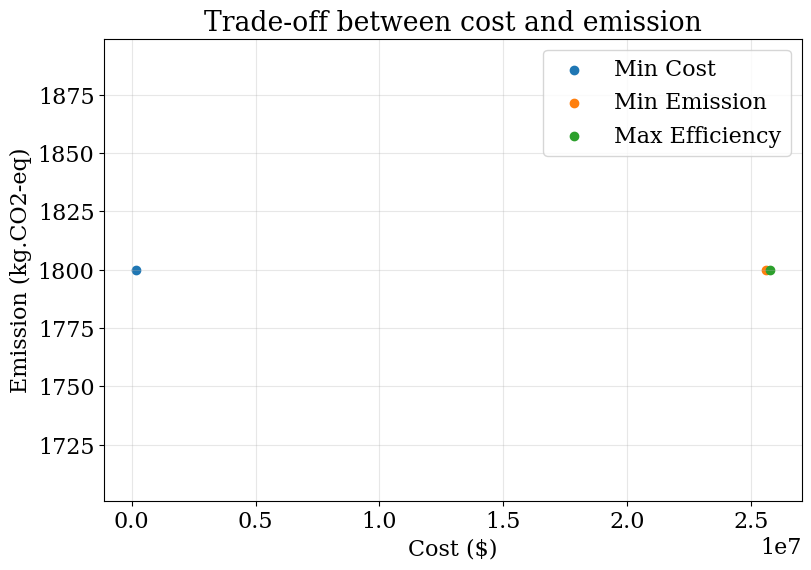

In [28]:
import matplotlib.pyplot as plt
from matplotlib import rc 
rc('font', **{'family': 'serif',
    'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize= (9,6))
plt.title('Trade-off between cost and emission')
plt.ylabel('Emission (kg.CO2-eq)')
plt.xlabel('Cost ($)')
ax.scatter(min_cost_x, min_cost_y, label = 'Min Cost')
ax.scatter(em_x, em_y, label = 'Min Emission')
ax.scatter(eff_x, eff_y, label = 'Max Efficiency')
plt.legend()
plt.grid(alpha=0.3)
plt.rcdefaults()
